In [2]:
import jax
print("jax version:", jax.__version__)
print("Devices:", jax.devices())

jax version: 0.4.23
Devices: [CpuDevice(id=0)]


In [13]:
import pandas as pd

df = pd.read_csv("data/df_indi_works.csv", index_col=0)
#df = pd.read_csv("data/df_indi_works_clean_gdp.csv", index_col=0)

print(len(df))

regions = pd.read_csv('data/ENS - Cultural Index - Countries Databases - region_level.csv')
regions = regions[regions['level'] == 2]
regions = set(regions['region_name'])
df = df[df['region_name'].isin(regions)]
df["century"] = df["decade"].round(-2)
df.head(n=10)
max(df.decade)

570466


1880

In [11]:
df

,individual_wikidata_id,birthyear,productive_year,decade,individual_name,region_code,region_name,count_works,century
2,Q202809,1803.0,1838.0,1840,Frederick Coombs,re_united_kingdom,United Kingdom,0.0,1800
4,Q4350107,1785.0,1820.0,1820,Vassili Perevoštšikov,re_eastern_europe,Eastern Europe,0.0,1800
5,Q4350107,1785.0,1820.0,1820,Vassili Perevoštšikov,re_slav_world,Slav world,0.0,1800
8,Q1028749,1683.0,1718.0,1720,Christian Friedrich Zincke,re_united_kingdom,United Kingdom,22.0,1700
12,Q2822993,1100.0,1135.0,1140,Achard of Saint-Victor,re_united_kingdom,United Kingdom,0.0,1100
...,...,...,...,...,...,...,...,...,...
570455,Q5549197,1837.0,1872.0,1870,Michael Anagnos,re_eastern_europe,Eastern Europe,0.0,1900
570459,Q55191347,1732.0,1767.0,1770,Jean-Baptiste Daubanton,re_france,France,0.0,1800
570461,Q43136014,1844.0,1879.0,1880,Alexandre Nicolaievich Roussoff,re_eastern_europe,Eastern Europe,0.0,1900
570462,Q43136014,1844.0,1879.0,1880,Alexandre Nicolaievich Roussoff,re_slav_world,Slav world,0.0,1900


In [10]:
len(df)

178901

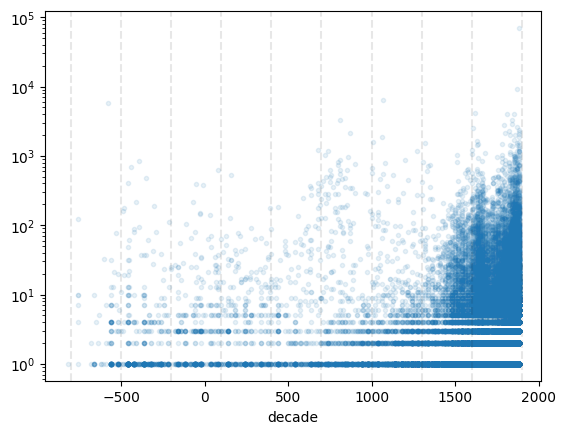

In [3]:
import matplotlib.pyplot as plt
import numpy as np

num_knots = 10
knots = np.linspace(df["century"].min(), df["century"].max(), num_knots)


fig, ax = plt.subplots()
(df.groupby(["decade", "individual_wikidata_id"])["count_works"].sum() + 1).droplevel(
    level="individual_wikidata_id").plot(style=".", alpha=0.1, logy=True, ax=ax)

for knot in knots:
    ax.axvline(knot, color="0.1", alpha=0.1, ls="--")

In [4]:
df['count'] = df['count_works']
df_m = df.copy()
df_m = df_m[df_m['count'].isin({0, 1, 2})] # Not more ?
df_m['y'] = df_m['count'].map({0: 0, 1: 0, 2: 1})
df_m.sample(10)

print(len(df_m))

157825


## Global B-Spline Analysis

In [5]:
import bambi as bmb
import arviz as az

iknots = knots[1:-1]


print(iknots)

sample = df_m

priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "common": bmb.Prior("Normal", mu=0, sigma=5),
}

m_splines = bmb.Model(
    'y ~ bs(decade, knots=iknots, intercept=True)', sample, family='bernoulli', priors=priors)
m_splines

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


[-500. -200.  100.  400.  700. 1000. 1300. 1600.]


       Formula: y ~ bs(decade, knots=iknots, intercept=True)
        Family: bernoulli
          Link: p = logit
  Observations: 157825
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.0)
            bs(decade, knots=iknots, intercept=True) ~ Normal(mu: 0.0, sigma: 5.0)

In [6]:
df_m[['decade', 'y']].sample(10)

,decade,y
108988,1790,0
399945,-660,0
283559,1850,0
29532,1820,0
469324,1840,0
224875,1870,0
164235,1860,0
450181,1790,0
321175,1710,0
524770,1850,0


In [35]:
p_splines = m_splines.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
az.summary(p_splines)

Modeling the probability that y==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, bs(decade, knots=iknots, intercept=True)]


In [7]:
def plot_knots(knots, ax):
    for knot in knots:
        ax.axvline(knot, color="0.1", alpha=0.4)
    return ax

def plot_predictions(data, idata, model, region=None, ax=None, plot_knot_lines=True, color="C0"):
    if ax is None:
        fig, ax = plt.subplots()
    
    new_data = {}
    if region is not None:
        data = data[data["region_name"] == region]
        new_data["region_name"] = [region] * 500
    new_data["decade"] = np.linspace(data["decade"].min(), data["decade"].max(), num=500)
    new_data = pd.DataFrame(new_data)

    model.predict(idata, data=new_data)

    posterior_stacked = az.extract(idata)
    # Extract these predictions
    y_hat = posterior_stacked["y_mean"]

    # Compute the mean of the predictions, plotted as a single line.
    y_hat_mean = y_hat.mean("sample")

    # Compute 94% credible intervals for the predictions, plotted as bands
    hdi_data = np.quantile(y_hat, [0.11, 0.89], axis=1)

    # Plot predicted line
    ax.plot(new_data["decade"], y_hat_mean, color=color, label=region)

    # Plot credibility bands
    ax.fill_between(new_data["decade"], hdi_data[0], hdi_data[1], alpha=0.4, color=color)

    # Add knots
    if plot_knot_lines:
        plot_knots(knots, ax)
    ax.set(xlabel="time", ylabel="p(n_obs=2)")

Plot the global probability of observing a producer twice in the dataset, i.e. $p(n_{\text{obs}} = 2)$:

In [ ]:
plot_predictions(sample, p_splines, m_splines);

## Global Spline Analysis with Varying Intercepts for Region

In [8]:
sample = df_m

priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "common": bmb.Prior("Normal", mu=0, sigma=5),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=5))
}

m_splines_vi = bmb.Model(
    'y ~ bs(decade, knots=iknots, intercept=True) + (1|region_name)', 
    sample, family='bernoulli', priors=priors)
m_splines_vi

       Formula: y ~ bs(decade, knots=iknots, intercept=True) + (1|region_name)
        Family: bernoulli
          Link: p = logit
  Observations: 157825
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.0)
            bs(decade, knots=iknots, intercept=True) ~ Normal(mu: 0.0, sigma: 5.0)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 5.0))

In [ ]:
p_splines_vi = m_splines_vi.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
az.summary(p_splines_vi)

## Varying Splines Analysis on Regions

In [9]:
sample = df_m

priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=2.5),
    "bs(decade, knots = iknots, intercept = True)|region_name": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=2.5))
}

m_splines_vs = bmb.Model(
    'y ~ 1 + (bs(decade, knots=iknots, intercept=True)|region_name)', 
    sample, family='bernoulli', priors=priors)
m_splines_vs

       Formula: y ~ 1 + (bs(decade, knots=iknots, intercept=True)|region_name)
        Family: bernoulli
          Link: p = logit
  Observations: 157825
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5)
        
        Group-level effects
            1|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.5))
            bs(decade, knots=iknots, intercept=True)|region_name ~ Normal(mu: 0.0, sigma: HalfNormal(sigma:
                [437.0669 145.5013  59.8242  53.3083  60.9401  69.2033  66.8432  44.1803
              22.7751  12.9171  12.0168   6.8756]))

In [10]:
p_splines_vs = m_splines_vs.fit(
    draws=1000, chains=4, inference_method='nuts_numpyro')  # important to run faster and sample more efficiently
az.summary(p_splines_vs)

Modeling the probability that y==1
/home/charles/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Compiling...
2023-12-29 17:23:27.741304: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.103). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/home/charles/.local/lib/python3.10/site-packages/pymc/sampling/jax.py:678: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginn

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.865,0.540,-3.317,-1.941,0.265,0.203,7.0,11.0,1.60
1|region_name_sigma,0.626,0.520,0.196,1.515,0.256,0.198,7.0,24.0,1.53
"bs(decade, knots=iknots, intercept=True)|region_name_sigma[0]",194.067,330.900,0.094,767.445,164.779,126.174,7.0,27.0,1.56
"bs(decade, knots=iknots, intercept=True)|region_name_sigma[1]",33.890,53.526,0.832,126.704,26.641,20.410,7.0,31.0,1.53
"bs(decade, knots=iknots, intercept=True)|region_name_sigma[2]",11.795,18.824,0.094,44.393,9.367,7.178,7.0,14.0,1.58
...,...,...,...,...,...,...,...,...,...
"bs(decade, knots=iknots, intercept=True)|region_name[11, Persian world]",-0.459,0.558,-1.325,0.140,0.250,0.201,8.0,27.0,1.48
"bs(decade, knots=iknots, intercept=True)|region_name[11, Portugal]",0.567,1.163,-0.433,2.556,0.572,0.443,7.0,23.0,1.53
"bs(decade, knots=iknots, intercept=True)|region_name[11, Slav world]",-0.914,1.398,-3.318,0.136,0.691,0.533,7.0,27.0,1.55
"bs(decade, knots=iknots, intercept=True)|region_name[11, Spain]",0.095,0.221,-0.256,0.383,0.084,0.062,8.0,79.0,1.40


Plot the regional probability of observing a producer twice in the dataset over time, i.e. 𝑝(𝑛obs=2):

In [42]:
def plot_knots(knots, ax):
    for knot in knots:
        ax.axvline(knot, color="0.1", alpha=0.4)
    return ax

def plot_predictions(data, idata, model, region=None, ax=None, plot_knot_lines=True, color="C0"):
    if ax is None:
        fig, ax = plt.subplots()
    
    new_data = {}
    if region is not None:
        data = data[data["region_name"] == region]
        new_data["region_name"] = [region] * 500
    new_data["decade"] = np.linspace(data["decade"].min(), data["decade"].max(), num=500)
    new_data = pd.DataFrame(new_data)

    model.predict(idata, data=new_data)

    posterior_stacked = az.extract(idata)
    # Extract these predictions
    y_hat = posterior_stacked["y_mean"]

    # Compute the mean of the predictions, plotted as a single line.
    y_hat_mean = y_hat.mean("sample")

    # Compute 94% credible intervals for the predictions, plotted as bands
    hdi_data = np.quantile(y_hat, [0.11, 0.89], axis=1)

    # Plot predicted line
    ax.plot(new_data["decade"], y_hat_mean, color=color, label=region)

    # Plot credibility bands
    ax.fill_between(new_data["decade"], hdi_data[0], hdi_data[1], alpha=0.4, color=color)

    # Add knots
    if plot_knot_lines:
        plot_knots(knots, ax)
    ax.set(xlabel="time", ylabel="p(n_obs=2)")

Text(0.5, 0.01, 'time')

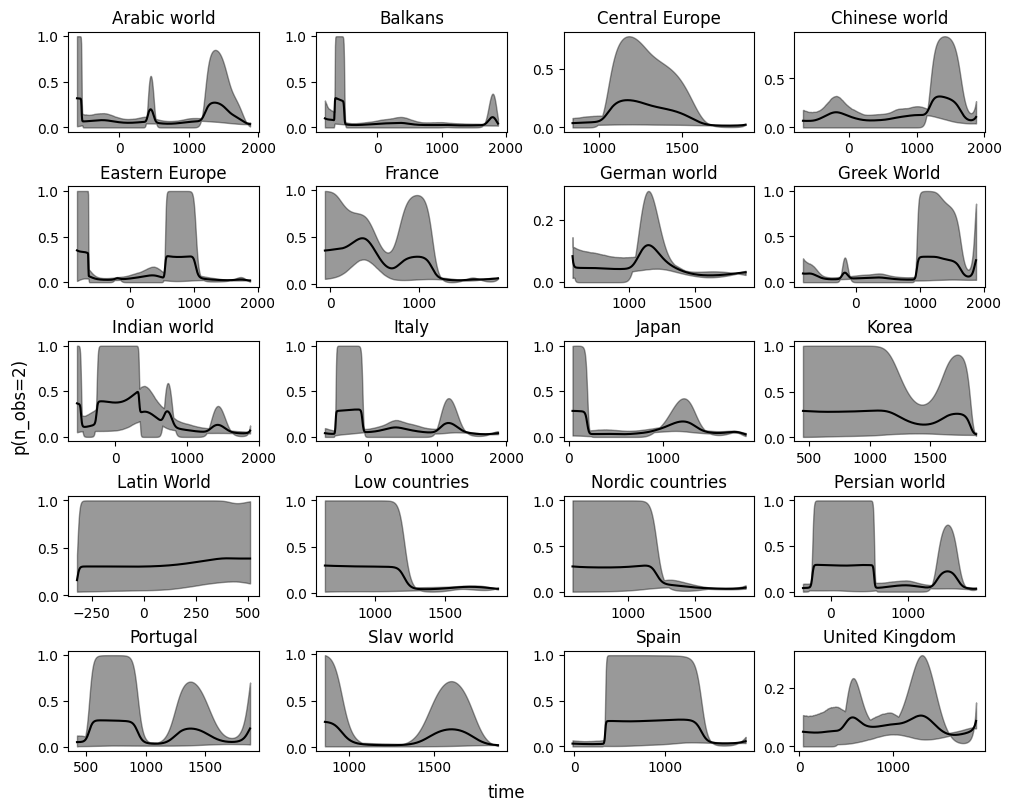

In [43]:
fig, axes = plt.subplots(ncols=4, nrows=5, figsize=(10, 8), constrained_layout=True)
axes = axes.flatten()

for i, region in enumerate(sorted(df_m["region_name"].unique())):
    plot_predictions(
        sample, p_splines_vs, m_splines_vs, region, ax=axes[i], color="k", plot_knot_lines=False);
    axes[i].set(title=region, xlabel="", ylabel="")

fig.supylabel('p(n_obs=2)')
fig.supxlabel('time')

In [45]:
def plot_estimations(data, obs_data, idata, model, region=None, ax=None, logy=False, 
                     plot_knot_lines=True, color="C0"):
    if ax is None:
        fig, ax = plt.subplots()
    
    new_data = {}
    data = data[data["region_name"] == region]
    obs_data = obs_data[obs_data["region_name"] == region]   
    
    new_data["decade"] = data["decade"].values 
    new_data["region_name"] = [region] * len(data["decade"].values)
    
    new_data = pd.DataFrame(new_data)
    
    model.predict(idata, data=new_data)

    posterior_stacked = az.extract(idata)
    # Extract these predictions
    p = posterior_stacked["y_mean"].values
    l = (2 * p) / (1 - p)
    f0 = (1 / (l + (l**2) / 2))

    decades = np.array(sorted(data["decade"].unique()))
    
    N_est = np.zeros((len(decades), f0.shape[1]))
    unseen = np.zeros((len(decades), f0.shape[1]))
    
    for i, decade in enumerate(decades):
        n_obs_di = data.loc[data["decade"] == decade, "individual_wikidata_id"].nunique()
        mask = (new_data["decade"] == decade).astype(int).values[:, None]
        f0_di = (f0 * mask).sum(0)
        S_di = n_obs_di + f0_di
        N_est[i] = S_di
        unseen[i] = f0_di

    # Compute 94% credible intervals for the predictions, plotted as bands
    hdi_data = np.quantile(N_est, [0.11, 0.89], axis=1)

    # Plot predicted line
    ax.plot(decades, N_est.mean(1), color=color, label=region)
    
    df[df["region_name"] == region].groupby("decade")["individual_wikidata_id"].count().plot(
        ax=ax, ls="--", color="red")
    
    # Plot credibility bands
    ax.fill_between(decades, hdi_data[0], hdi_data[1], alpha=0.4, color=color)

    # Add knots
    if plot_knot_lines:
        plot_knots(knots, ax)
    ax.set(xlabel="time", ylabel="Estimated diversity")
    if logy:
        ax.set_yscale("log")
    
    return unseen, N_est, hdi_data, decades

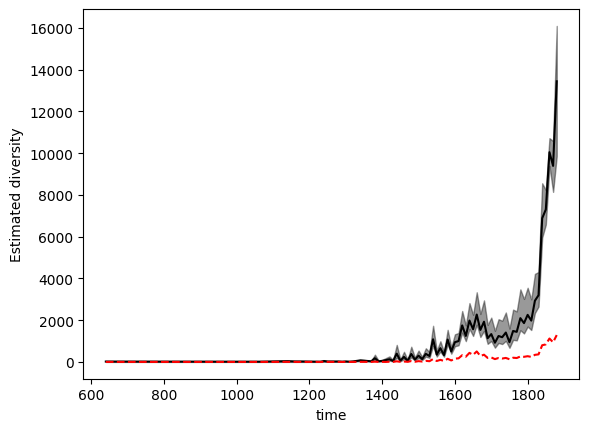

In [52]:
plot_estimations(
    sample, df, p_splines_vs, m_splines_vs, "Low countries", color="k", plot_knot_lines=False, logy =False);

Text(0.5, 0.01, 'time')

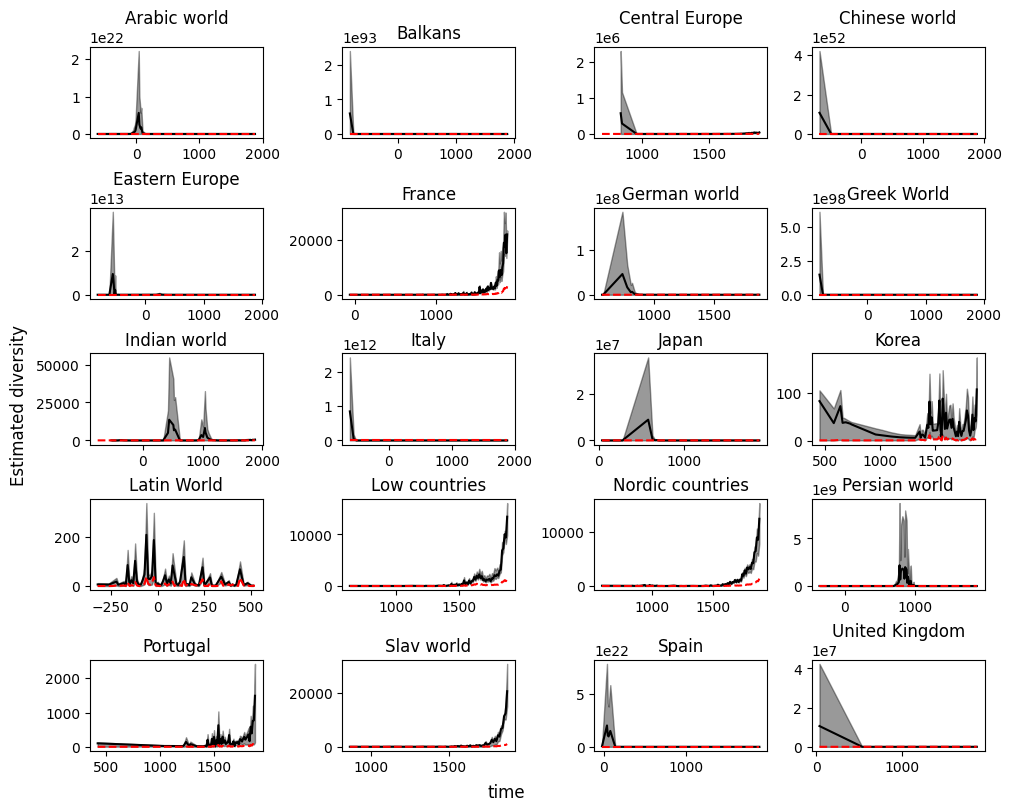

In [146]:
fig, axes = plt.subplots(ncols=4, nrows=5, figsize=(10, 8), constrained_layout=True)
axes = axes.flatten()

results = {}
for i, region in enumerate(sorted(df_m["region_name"].unique())):
    f0, N_est, hdi, decades = plot_estimations(
        sample, df, p_splines_vs, m_splines_vs, region, ax=axes[i], color="k", plot_knot_lines=False);
    axes[i].set(title=region, xlabel="", ylabel="")
    results[region] = f0, N_est, hdi, decades

fig.supylabel('Estimated diversity')
fig.supxlabel('time')

In [147]:
def plot_trend(decades, N_est, hdi_data, color="C0", label=None, ax=None, logy=False, figsize=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Plot predicted line
    ax.plot(decades, N_est.mean(1), color=color, label=label)

    # Plot credibility bands
    ax.fill_between(decades, hdi_data[0], hdi_data[1], alpha=0.4, color=color)

    ax.set(xlabel="time", ylabel="Estimated diversity")
    if logy:
        ax.set_yscale("log")

    return ax

(1200.0, 1900.0)

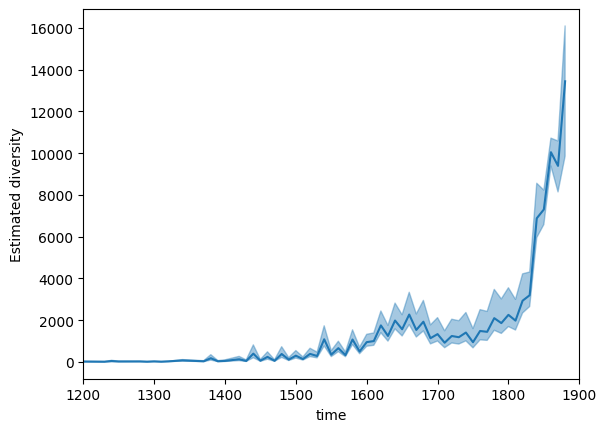

In [148]:
f0, N_est, hdi, decades = results["Low countries"]

ax = plot_trend(decades, N_est, hdi, label="Low countries")
ax.set_xlim(1200, 1900)

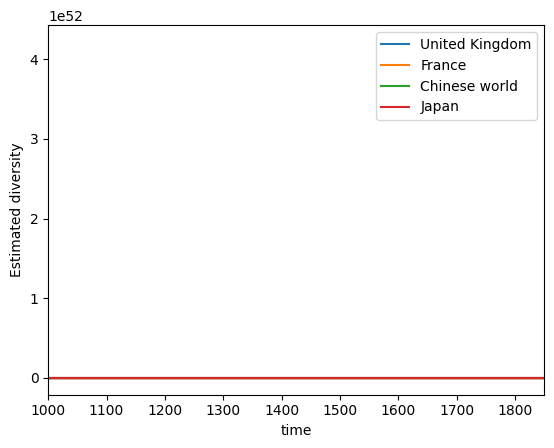

In [149]:
regions = "United Kingdom", "France", "Chinese world", "Japan"

fig, ax = plt.subplots()
for i, region in enumerate(regions):
    f0, N_est, hdi, decades = results[region]
    ax = plot_trend(decades, N_est, hdi, color=f"C{i}", logy=False, label=region, ax=ax)
ax.set_xlim(1000, 1850)
ax.legend()

In [150]:
import pickle

with open("regression-dump.pickle", "wb") as out:
    pickle.dump(results, out)

In [151]:
table = []
for region in results:
    _, N_est, hdi, decades = results[region]
    N_est = N_est.mean(1)
    li, ui = hdi[0], hdi[1]
    print(N_est.shape, li.shape, ui.shape, decades.shape)
    table.append(pd.DataFrame({
        "N_est": N_est,
        "lower": li,
        "upper": ui,
        "decade": decades,
        "region": [region] * N_est.shape[0]
    }))
table = pd.concat(table)
table.head()

(183,) (183,) (183,) (183,)
(127,) (127,) (127,) (127,)
(69,) (69,) (69,) (69,)
(185,) (185,) (185,) (185,)
(143,) (143,) (143,) (143,)
(113,) (113,) (113,) (113,)
(95,) (95,) (95,) (95,)
(187,) (187,) (187,) (187,)
(99,) (99,) (99,) (99,)
(159,) (159,) (159,) (159,)
(114,) (114,) (114,) (114,)
(70,) (70,) (70,) (70,)
(59,) (59,) (59,) (59,)
(69,) (69,) (69,) (69,)
(80,) (80,) (80,) (80,)
(109,) (109,) (109,) (109,)
(65,) (65,) (65,) (65,)
(56,) (56,) (56,) (56,)
(96,) (96,) (96,) (96,)
(92,) (92,) (92,) (92,)


,N_est,lower,upper,decade,region
0,4.505820e+02,1.000000,3.769945e+01,-610,Arabic world
1,1.561616e+02,3.526011,5.763430e+02,-520,Arabic world
2,4.670903e+12,10.301140,1.870820e+13,-360,Arabic world
3,7.263272e+12,3.375488,2.906964e+13,-330,Arabic world
4,1.107538e+13,3.353761,4.431526e+13,-320,Arabic world


In [ ]:
#table.to_csv("results/estimations.csv", index=False)
#table.to_csv("results/estimations_clean_gdp.csv", index=False)